### Student Information
Name: 李承諭

Student ID: 109501009

GitHub ID: #95518319

Kaggle name: Davidalus

Kaggle private scoreboard snapshot: 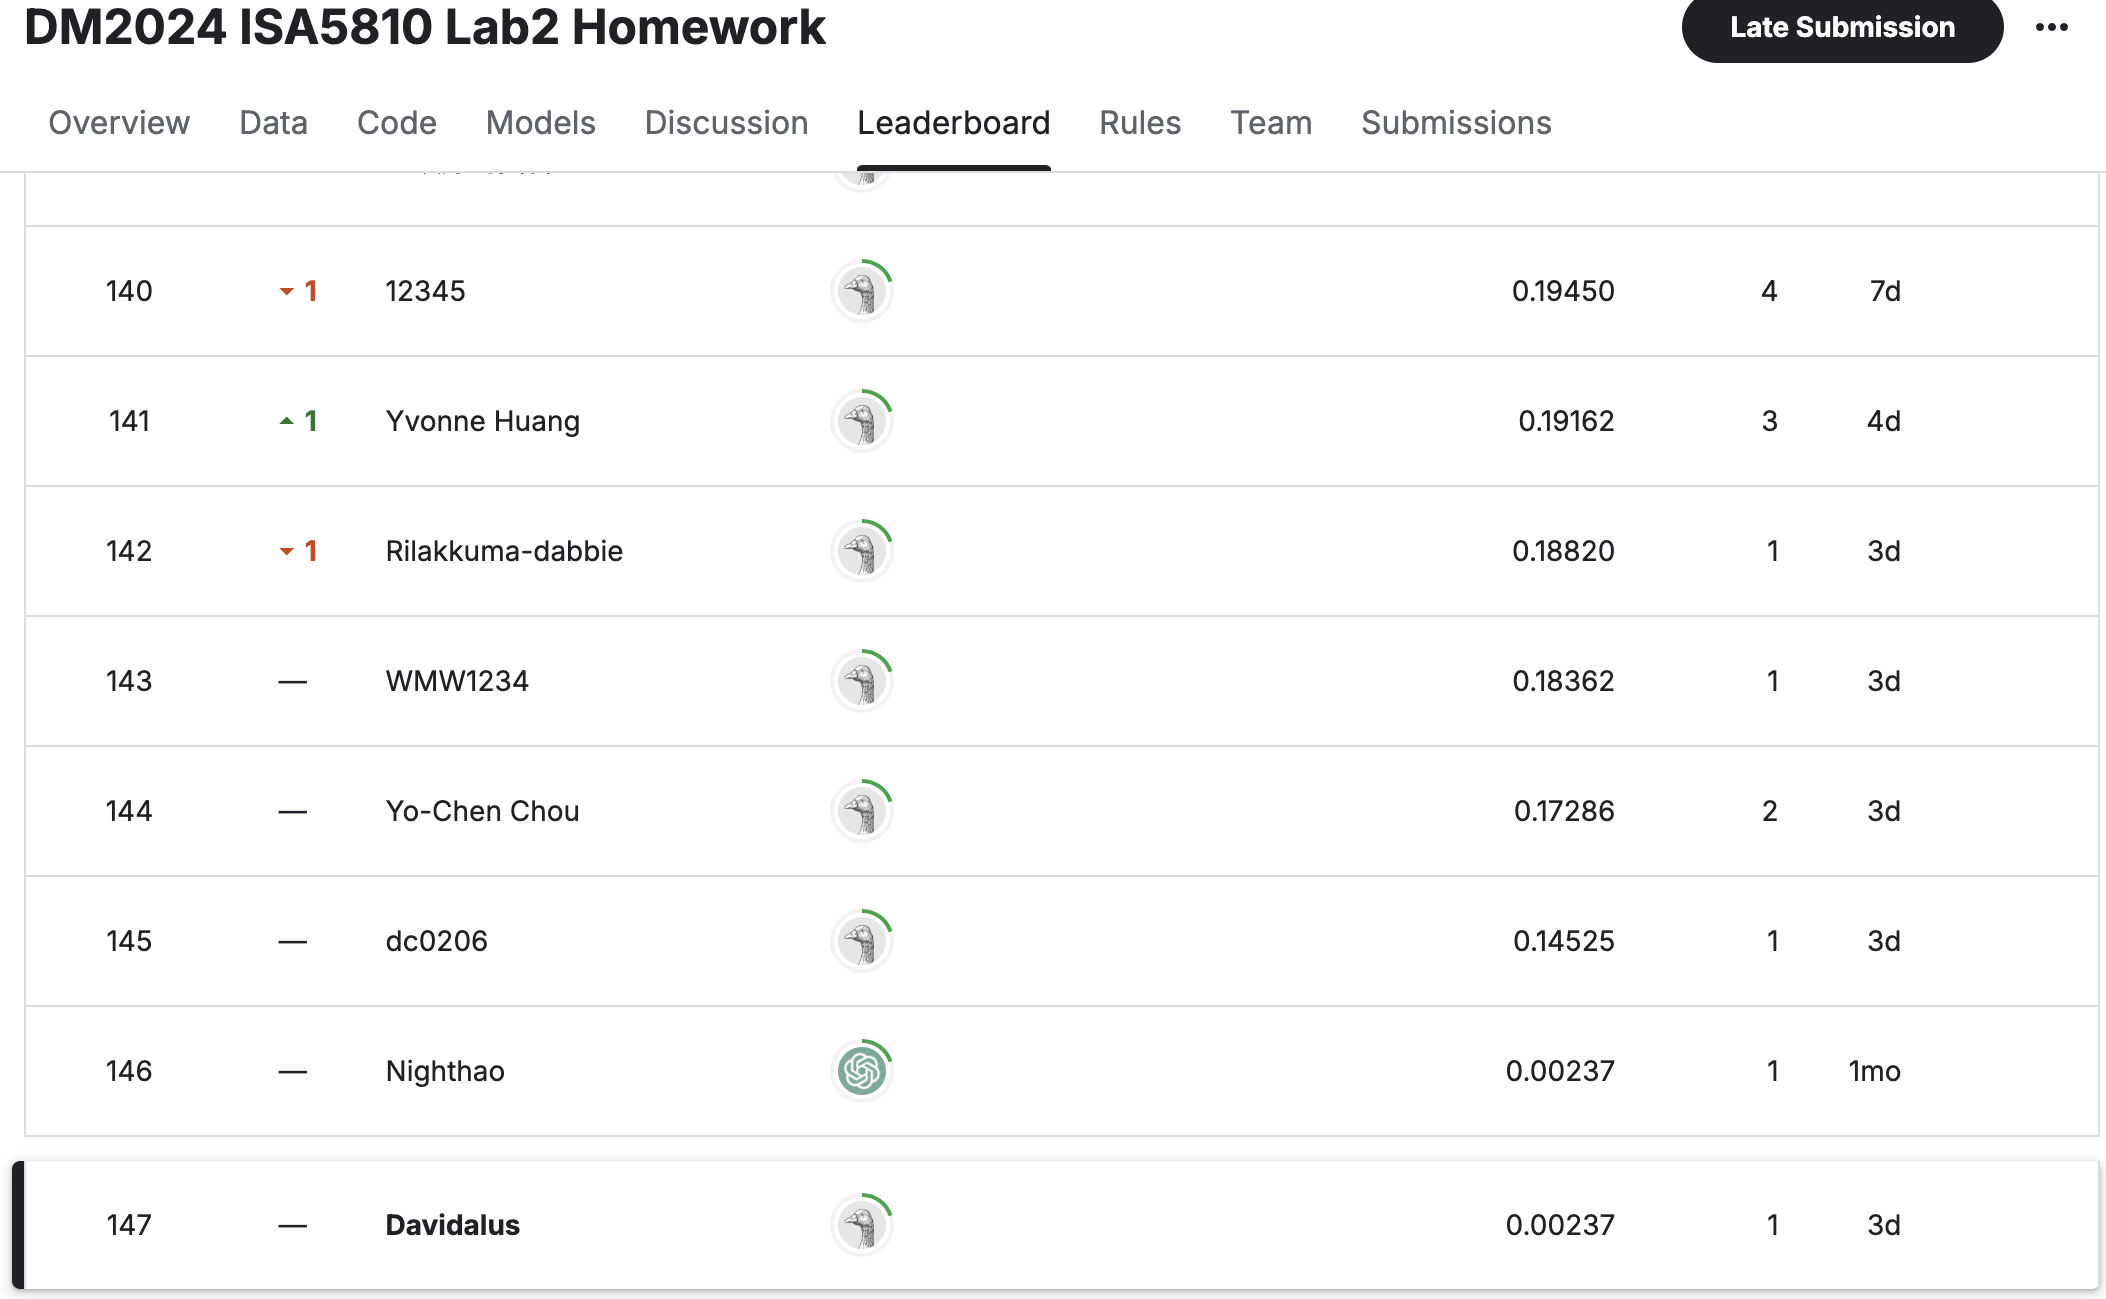
My Submission Score (after 1206, on 1207): 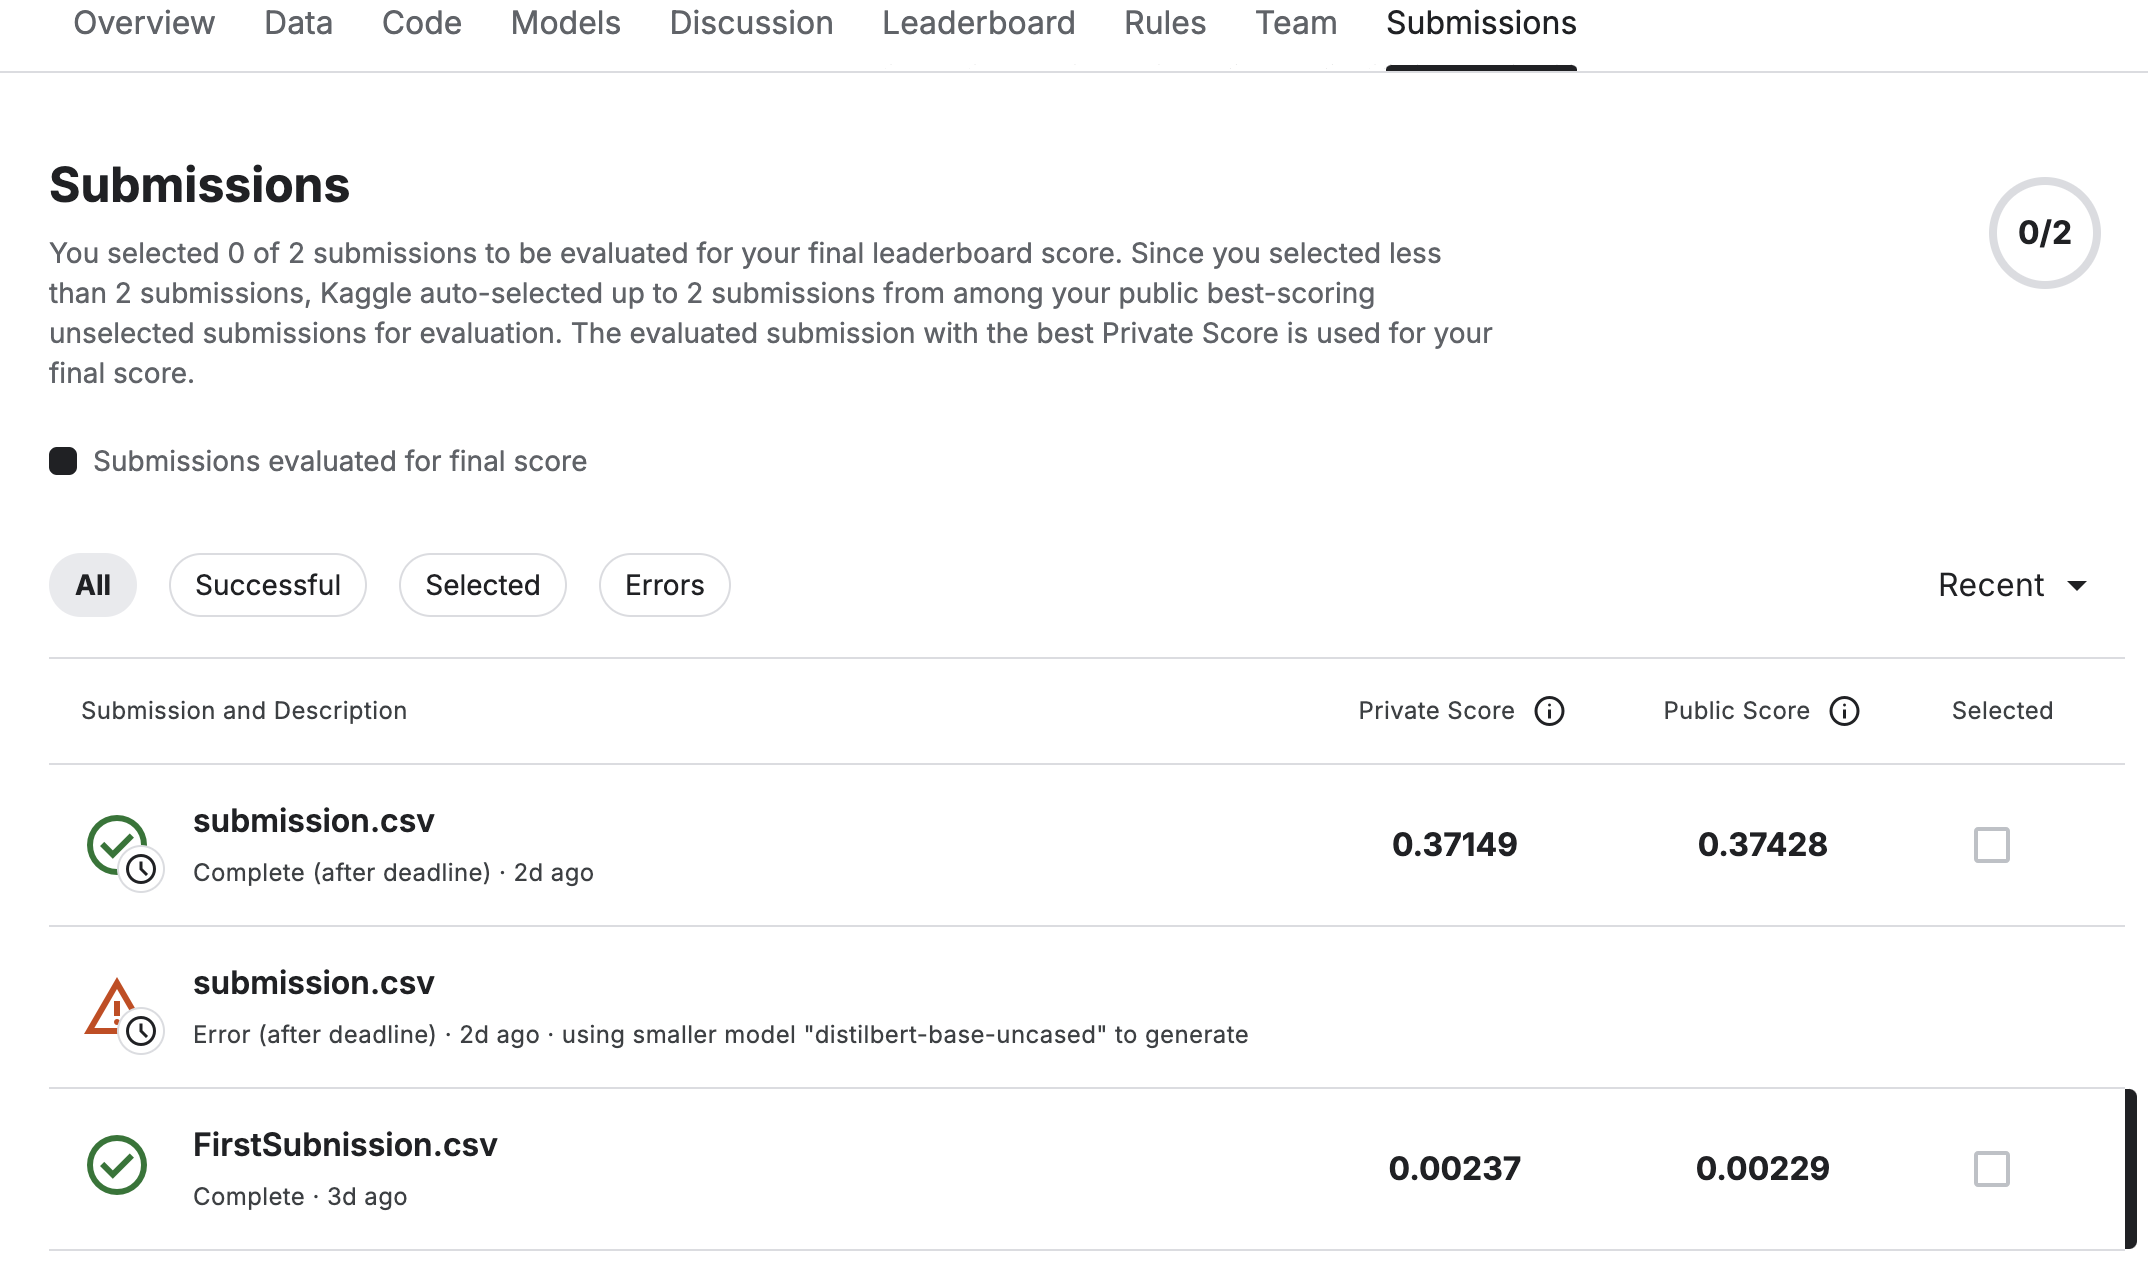
If my Submission Score on private scoreboard(rank 99): 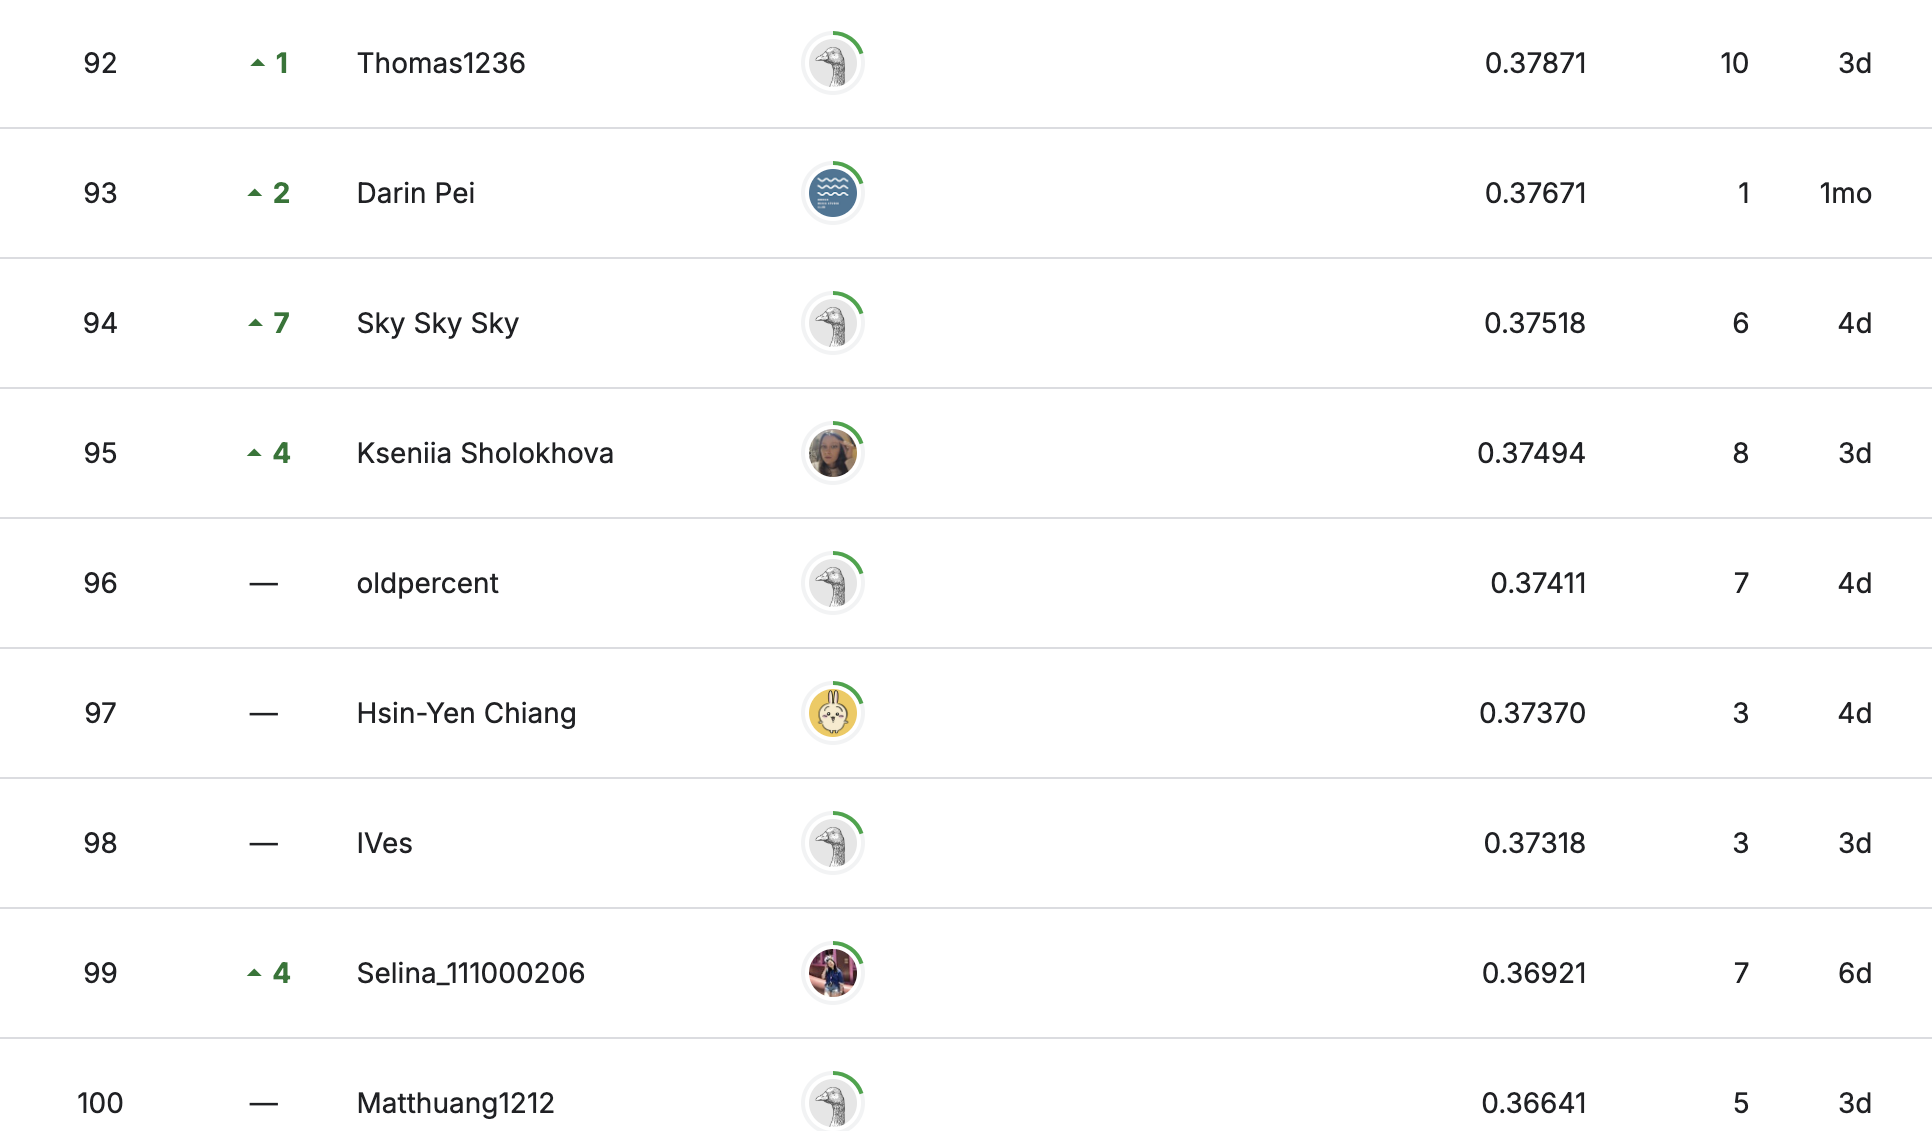

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

In [2]:
### Begin Assignment Here
import pandas as pd
import json
import re
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Load data
with open("tweets_DM.json", "r") as file:
    raw_tweets = json.loads("[" + ",".join(file.readlines()) + "]")
tweets_df = pd.DataFrame(raw_tweets)

# Data preprocessing
tweets_df['_source'] = tweets_df['_source'].apply(lambda x: json.loads(json.dumps(x)))
tweets_flat = pd.json_normalize(tweets_df['_source'])
tweets_df['tweet_id'] = tweets_flat['tweet.tweet_id']
tweets_df['text'] = tweets_flat.get('tweet.text', None)

# Load emotion and dataset labels
emotion_df = pd.read_csv("emotion.csv")
data_identification_df = pd.read_csv("data_identification.csv")

# Clean column names
emotion_df.columns = emotion_df.columns.str.strip().str.lower()
data_identification_df.columns = data_identification_df.columns.str.strip().str.lower()

# Merge data
tweets_df = tweets_df.merge(emotion_df, on="tweet_id", how="left")
tweets_df = tweets_df.merge(data_identification_df, on="tweet_id", how="left")

# Split train/test
train_data = tweets_df[tweets_df['identification'] == 'train']
test_data = tweets_df[tweets_df['identification'] == 'test']

# Text preprocessing
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    return text.lower()

train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

# Model and tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Label mapping
emotion_labels = train_data['emotion'].unique()
label_to_id = {label: idx for idx, label in enumerate(emotion_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}
train_data['label'] = train_data['emotion'].map(label_to_id)

# Sampling to reduce training time
train_data = train_data.sample(n=min(10000, len(train_data)), random_state=42)

# Split train and validation
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Create datasets
train_dataset = Dataset.from_pandas(train_data[['text', 'label']])
val_dataset = Dataset.from_pandas(val_data[['text', 'label']])
test_dataset = Dataset.from_pandas(test_data[['text']])

# Tokenization
def tokenize_function(data):
    return tokenizer(data['text'], padding="max_length", truncation=True, max_length=64)  # Reduced max_length

train_encoded = train_dataset.map(tokenize_function, batched=True)
val_encoded = val_dataset.map(tokenize_function, batched=True)
test_encoded = test_dataset.map(tokenize_function, batched=True)

# Model and training arguments
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=len(emotion_labels)
)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    num_train_epochs=2,  # Reduced epochs
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encoded,
    eval_dataset=val_encoded,
)

# Train
trainer.train()

# Predictions
test_encoded = test_encoded.add_column("label", [0] * len(test_encoded))
raw_preds = trainer.predict(test_encoded)
predicted_labels = raw_preds.predictions.argmax(axis=1)

# Create submission
test_data['emotion'] = [id_to_label[label] for label in predicted_labels]
test_data[['tweet_id', 'emotion']].to_csv("submission.csv", index=False)

Since I run my code on another jupyter notebook, considering rerunning it is very time-consuming (it took me 18 hours in total to get the result csv.), here I just pasted the code and show the graph of running related result: 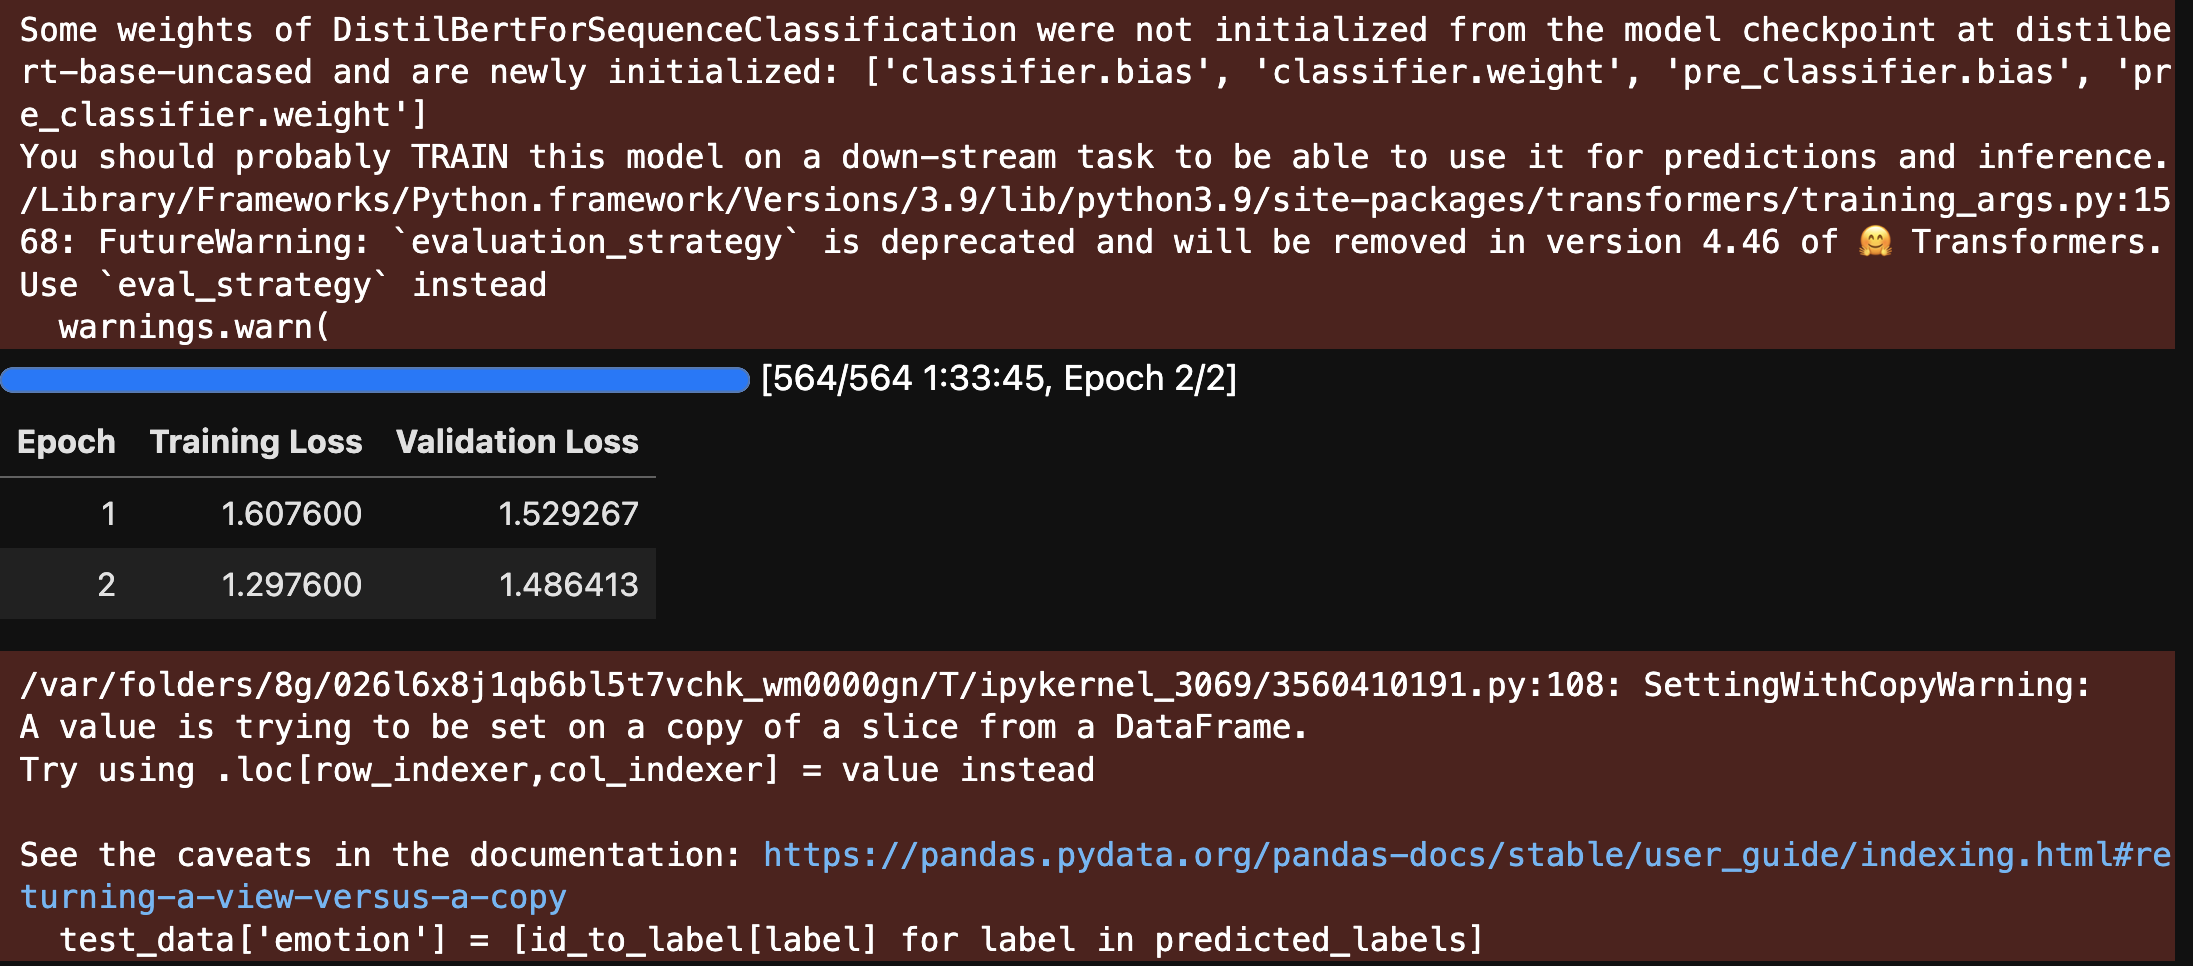